In [1]:
import tensorflow as tf
from os import path
import sys
tf.logging.set_verbosity(tf.logging.ERROR)
sys.path.append(path.join("../.."))

In [2]:
%%html
<style>
table {
    float: left;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In this example, we used two datasets of pancreatic cells

In [3]:
EPOCHS = 200

In [4]:
import saly
import saly.backend as S
from NoMarkers_utility import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Human'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
#DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
#DATA_PATH = 'D:/Data/SingleCellGeneExpression/'
DATASET_BARON_PATH = DATA_PATH + 'baron_2016h.h5ad' 
DATASET_XIN_PATH = DATA_PATH + 'xin_2016.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [5]:
baron_data, baron_labels = saly.load_h5ad(DATASET_BARON_PATH)
xin_data, xin_labels = saly.load_h5ad(DATASET_XIN_PATH)

### Baron

In [6]:
print(baron_data.shape)
baron_labels.unique()

(8569, 20125)


[Acinar cells, Beta cells, Delta cells, PaSC, Ductal cells, Alpha cells, Other, PP cells, Endothelial cell]
Categories (9, object): [Acinar cells, Beta cells, Delta cells, PaSC, ..., Alpha cells, Other, PP cells, Endothelial cell]

Baron has 8569 cells and 20125 genes.

The cells are classified into 9 classes: Acinar cells, Alpha cells, Beta cells, Delta cells, Ductal cells, Endothelial cells, ***Other***, PaSC (i.e. Pancreatic stellate cells) and PP cells (i.e. Gamma cells).

### Xin

In [7]:
print(xin_data.shape)
xin_labels.unique()

(1492, 39851)


[Beta cells, Alpha cells, Delta cells, PP cells]
Categories (4, object): [Beta cells, Alpha cells, Delta cells, PP cells]

Xin has 1492 cells and 39851 genes.

The cells are classified into 4 classes: Alpha cells, Beta cells, Delta cells and PP cells (i.e. Gamma cells).

# Drop rows

We removed every cell classified as 'Other' from the Baron dataset.

In [8]:
baron_data, baron_labels = saly.drop_rows(baron_data, baron_labels, ['Other'])

Dropped 118 cell(s). New shape: (8451, 20125)


This removed 118 cells from Baron, leaving us with 8451 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [9]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [10]:
markers = saly.get_mutual_markers([baron_data.columns, xin_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [11]:
print(len(S.get_used_markers(baron_data.columns, markers_db)), len(S.get_used_markers(xin_data.columns, markers_db)))
print(len(markers))

7618 7610
7545


Baron has 7618 markers, and Xin has 7610.

We used only those found in both datasets (7545).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [12]:
marker_aliases = {'PaSC' : 'Pancreatic stellate cells',
                  'PP cells' : 'Gamma (PP) cells',
                  'Endothelial cell' : 'Endothelial cells'}

saly.check_labels([baron_labels, xin_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [13]:
baron_data = saly.drop_unused_genes(baron_data, markers)
xin_data = saly.drop_unused_genes(xin_data, markers)

Dropped 15952 gene(s). New shape: (8451, 4173)
Dropped 35678 gene(s). New shape: (1492, 4173)


After this operation we are left with 4173 genes.

#### Make sure the data sets' shapes match

In [14]:
saly.check_shape([baron_data, xin_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [15]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = saly.preprocess_data(baron_data, baron_labels,
                                                                                          train=0.7, validation=0.15,
                                                                                          test=0.15)

#### Log10 transform the Xin data, too

In [16]:
xin_data = S.log_10(xin_data)

# Building the model

We trained the network for 200 epochs.

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4173 (genes)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4173 (genes)|

#### Create the model

In [17]:
model, bottleneck_model = build_model(baron_data, markers);

# Train the model

In [ ]:
history = train_model(model, train_x, EPOCHS, validation_data=(validation_x, validation_x), verbose=0);

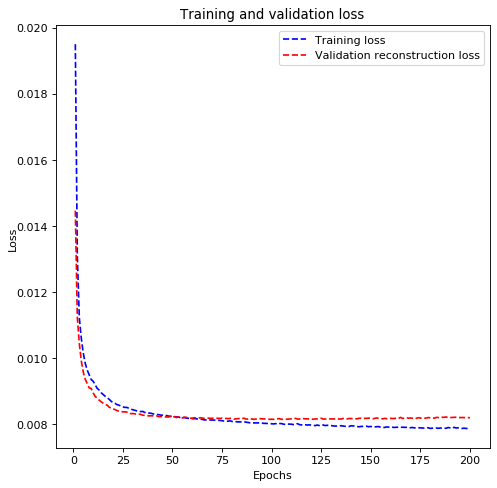

0.008226353466534277

In [20]:
plot_model_history(history)
test_model(model, test_x)

# Data analysis

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('../Data/baron_xin_label_colours.pickle') 

## Baron predictions

In [22]:
baron_cell_activations = model.predict(test_x)
baron_bottleneck_activations = bottleneck_model.predict(test_x)

The graph below shows the mean cell type activations. Note that only one cell type explicitly activates.

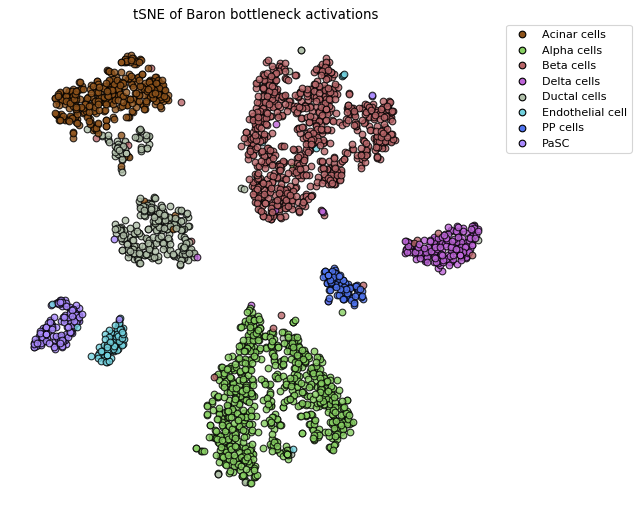

In [23]:
saly.draw_embedding(baron_bottleneck_activations, test_y, tsne, colours=colours, alpha=0.8,
                    graph_title='tSNE of Baron bottleneck activations');

## Xin predictions

In [24]:
xin_cell_activations = model.predict(xin_data)
xin_bottleneck_activations = bottleneck_model.predict(xin_data)

The network correctly classifies almost 100% of data from a completely new data set.

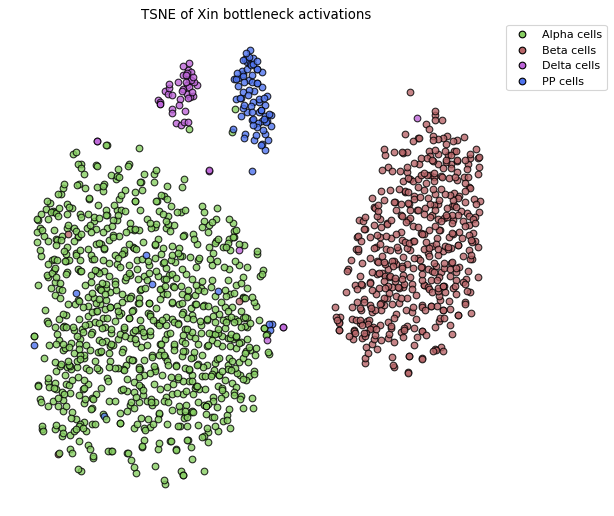

In [25]:
saly.draw_embedding(xin_cell_activations, xin_labels, tsne, colours=colours, alpha=0.8,
                    graph_title='TSNE of Xin bottleneck activations');

# Combined data

Here we see if our marker activations still have batch effects.

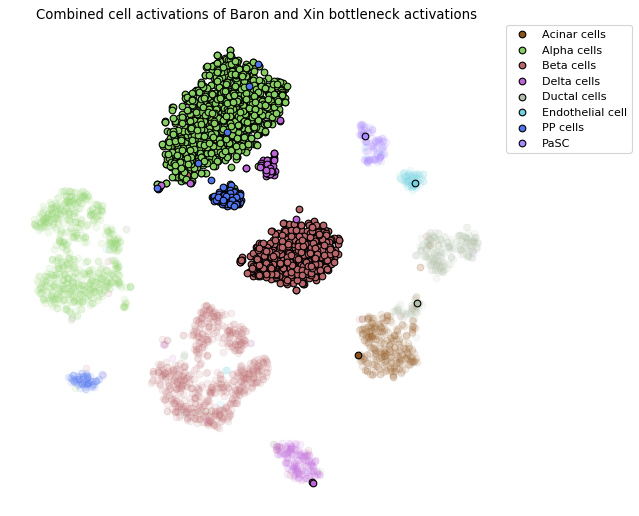

In [26]:
saly.draw_comparison([baron_cell_activations, test_y], [xin_cell_activations, xin_labels] ,tsne, colours=colours,
                     graph_title='Combined cell activations of Baron and Xin bottleneck activations')

# Top 3 activations

We also tried to see if taking only the top 3 cell activations would help us remedy the batch effect.

In [27]:
baron_top_3 = saly.get_top_activations(3, baron_bottleneck_activations)
xin_top_3 = saly.get_top_activations(3, xin_bottleneck_activations)

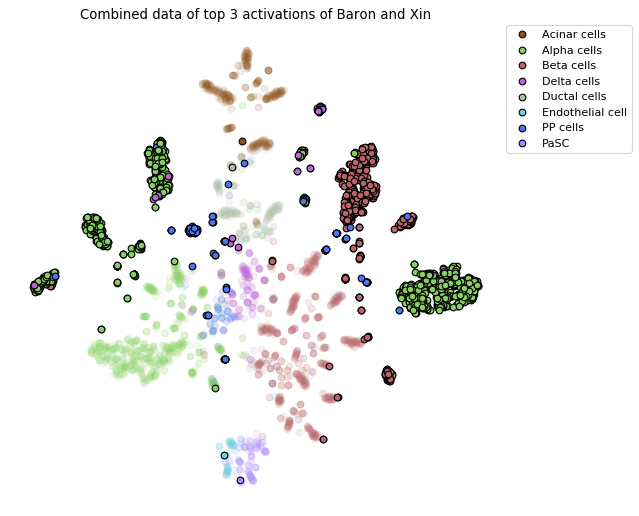

In [28]:
saly.draw_comparison([baron_top_3, test_y], [xin_top_3, xin_labels], tsne, colours=colours,
                     graph_title='Combined data of top 3 activations of Baron and Xin')